# Predicción de la TRM usando redes neuronales

## Implementación en Pytorch

In [0]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch.autograd import Variable
import torch


In [0]:
df = pd.read_excel('/content/Datos históricos USD_COP  BDordv2.xlsx')


In [0]:
df.tail(10)

,Index,Unnamed: 1,Fecha (dd/mm/aaaa),TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_EfcRate,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
1825,1826,mar,2019-12-31,3277.14,8.094726,0.042570,0.045470,0.055721,0.064371,0.010608,0.017666,0.024734,1.55,1.75,61.06,1529.30,-16.91,-0.005147,3288.138,3329.6495
1826,1827,mié,2020-01-01,3277.14,8.094726,0.042570,0.045470,0.055721,0.064371,0.010608,0.017666,0.024734,1.55,1.75,61.33,1520.95,0.00,0.000000,3287.286,3324.1200
1827,1828,jue,2020-01-02,3277.14,8.094726,0.042590,0.045902,0.055811,0.064531,0.010608,0.017666,0.024734,1.55,1.75,61.18,1540.10,0.00,0.000000,3283.904,3319.3655
1828,1829,vie,2020-01-03,3258.84,8.089127,0.042600,0.044759,0.056100,0.064821,0.008447,0.018163,0.024892,1.55,1.75,63.05,1564.50,-18.30,-0.005600,3276.862,3313.5930
1829,1830,sáb,2020-01-04,3262.05,8.090111,0.042585,0.044887,0.055864,0.064622,0.008610,0.017911,0.024917,1.55,1.75,63.16,1572.70,3.21,0.000985,3270.462,3307.9810
1830,1831,dom,2020-01-05,3262.05,8.090111,0.042585,0.044887,0.055864,0.064622,0.008610,0.017911,0.024917,1.55,1.75,63.16,1572.70,0.00,0.000000,3267.444,3302.3690
1831,1832,lun,2020-01-06,3262.05,8.090111,0.042585,0.044887,0.055864,0.064622,0.008610,0.017911,0.024917,1.55,1.75,63.27,1580.90,0.00,0.000000,3264.426,3297.2595
1832,1833,mar,2020-01-07,3262.05,8.090111,0.042570,0.045015,0.055629,0.064423,0.008773,0.017659,0.024943,1.55,1.75,62.70,1586.30,0.00,0.000000,3261.408,3292.9690
1833,1834,mié,2020-01-08,3264.26,8.090788,0.042540,0.044515,0.054818,0.063715,0.008803,0.017359,0.024996,1.55,1.75,59.61,1572.30,2.21,0.000677,3262.492,3289.6830
1834,1835,jue,2020-01-09,3254.42,8.087769,0.042550,0.044411,0.054333,0.062871,0.009567,0.017183,0.024514,1.55,1.75,59.56,1566.40,-9.84,-0.003019,3260.966,3286.2850


In [0]:
# 1) solo usamos trmlast y y1 que corresponde al valor de t+1   

#tomamos los datos del 1 de enero de 2015 al 31 de mayo 2019 para train tests split.
#los datos del 3 de junio 2019 al 1 enero 2020 lo tomamos como datos de validacion

# train test split 

xtrain = df['TRM'].loc[572:1376]
xtest =  df['TRM'].loc[228:571]
xval = df['TRM'].loc[1826:1834]

xtotal = df['TRM'].loc[1500:1834]


# standarizacion de los datos

scaler = StandardScaler()
train = scaler.fit_transform(xtrain.to_numpy().reshape(-1,1))
test = scaler.transform(xtest.to_numpy().reshape(-1,1))
val = scaler.transform(xval.to_numpy().reshape(-1,1))

# entrenamiento con todos los datos


total = scaler.fit_transform(xtotal.to_numpy().reshape(-1,1))




In [0]:
xtotal

1500    3115.94
1501    3115.94
1502    3115.94
1503    3132.61
1504    3131.10
         ...   
1830    3262.05
1831    3262.05
1832    3262.05
1833    3264.26
1834    3254.42
Name: TRM, Length: 335, dtype: float64

In [0]:
from torch.autograd import Variable
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var
seq_len = 100



In [0]:
seq_len = 100
x_train, y_train = transform_data(train, seq_len)
x_val, y_val = transform_data(val, seq_len)
x_test, y_test = transform_data(test, seq_len)

## datos totales

x_total, y_total = transform_data(total, seq_len)

In [0]:
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
torch.manual_seed(1)

In [0]:
#hyper Parameters

#TIME_STEP = 10  #rnn time step
INPUT_SIZE = 1  #RNN input size
LR = 0.02       #learning rate
HIDDEN_SIZE = 32


In [0]:
class RNN (nn.Module):
  def __init__(self):
    super(RNN,self).__init__()

    self.rnn =nn.RNN(
        input_size = INPUT_SIZE,
        hidden_size = HIDDEN_SIZE, #rnn hidden unit
        num_layers = 1,  #number of rnn layer
        batch_first = True,  #
    )
    self.out = nn.Linear(HIDDEN_SIZE,1)

  def forward (self, x, h_state):
    r_out, h_state =self.rnn(x,h_state)

    outs = [] #save al predictions
    for time_step in range(r_out.size(1)): #calculate the output for each time step
      outs.append(self.out(r_out[:,time_step,:]))
    return torch.stack(outs,dim=1), h_state

In [0]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [0]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR) #funcion de optimizacion Adam
loss_func = nn.MSELoss()

In [0]:
h_state = None  # para el hidden state inicial

In [0]:
plt.figure(1, figsize=(12,5))
plt.ion() #plotea continuo

<Figure size 864x360 with 0 Axes>

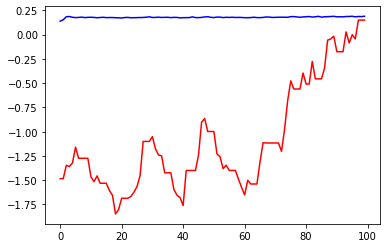

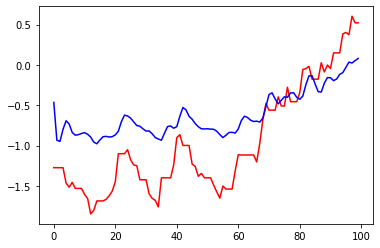

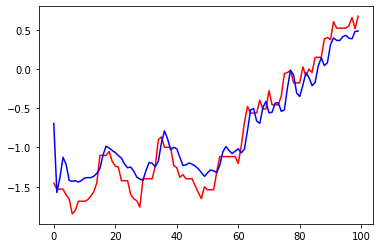

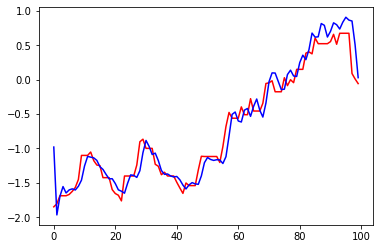

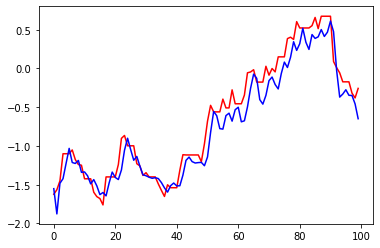

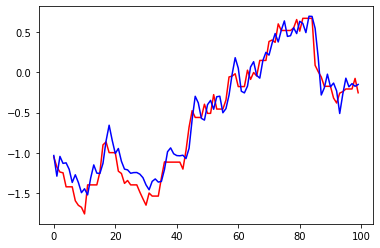

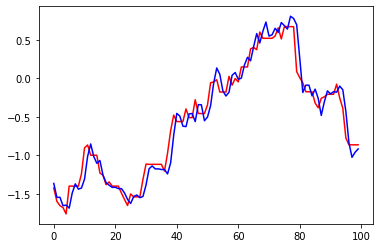

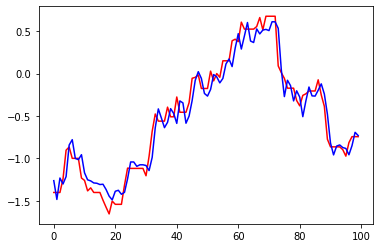

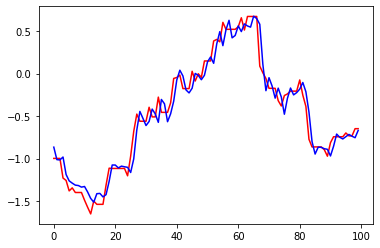

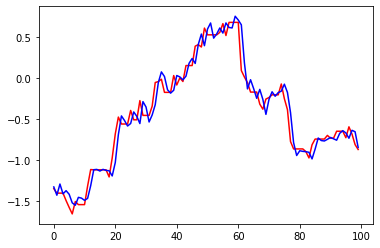

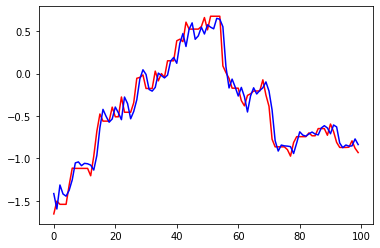

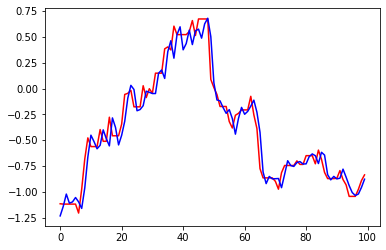

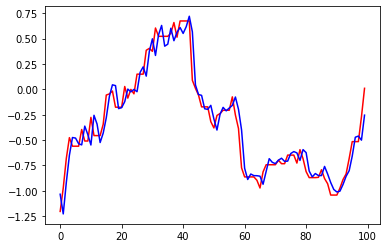

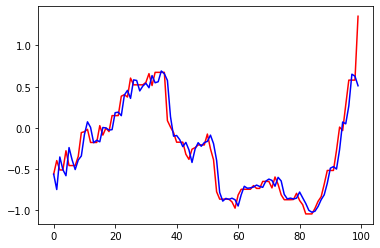

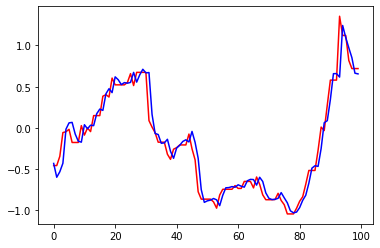

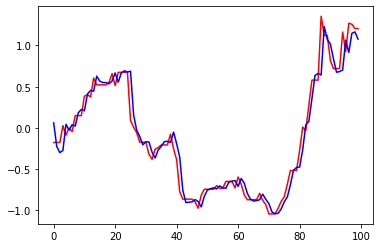

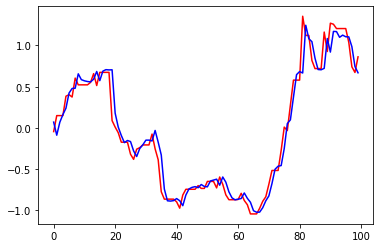

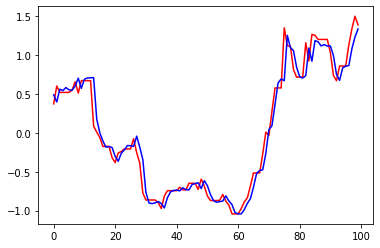

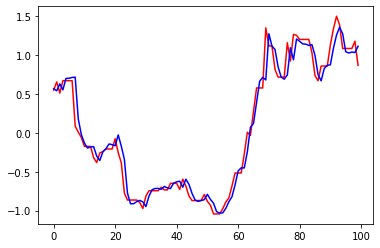

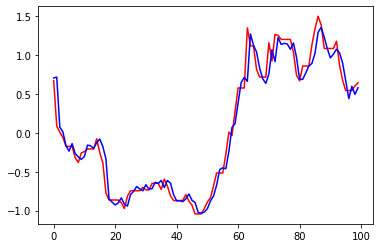

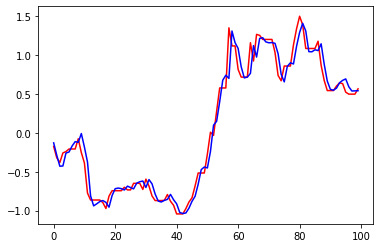

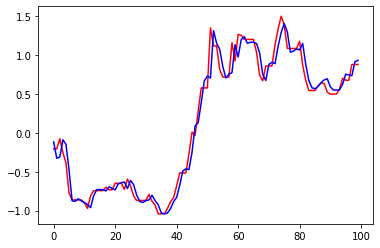

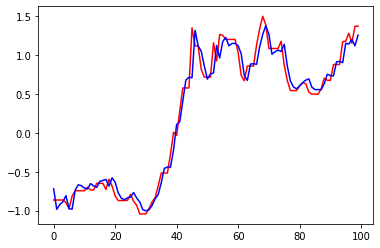

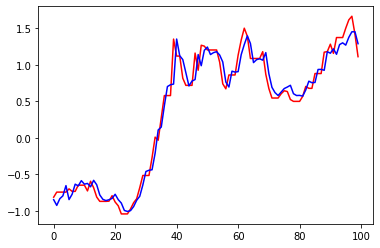

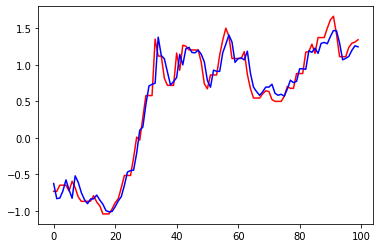

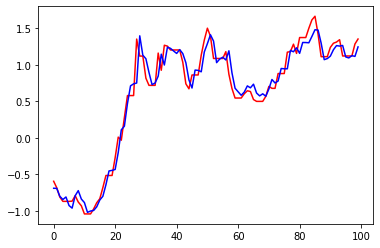

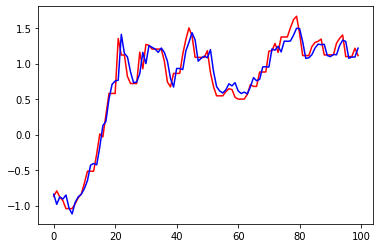

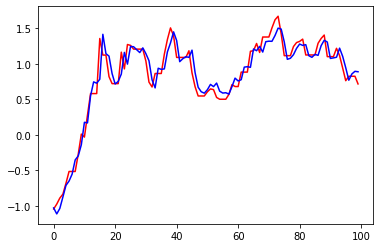

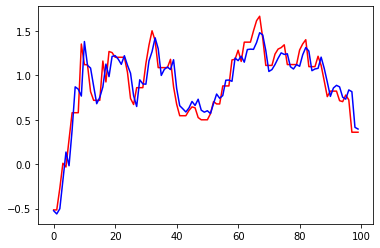

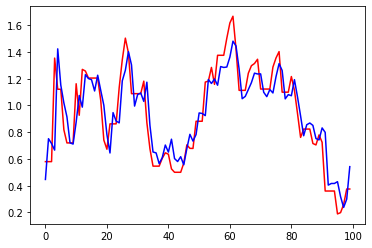

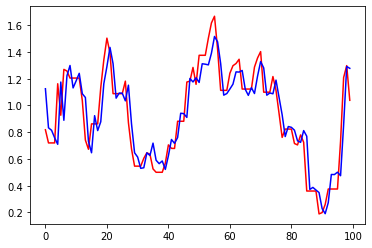

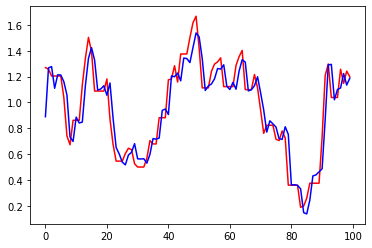

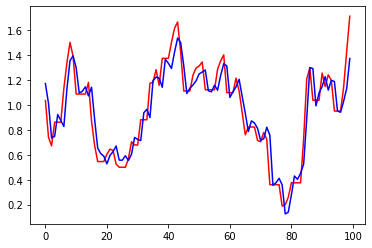

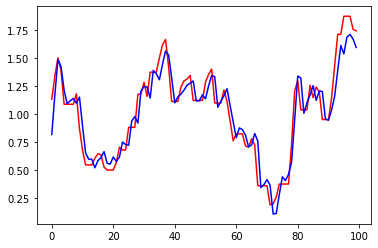

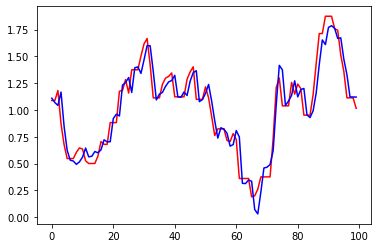

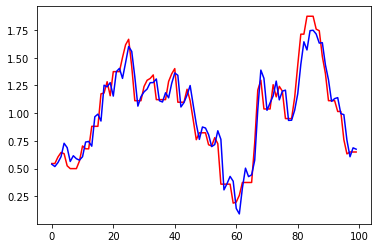

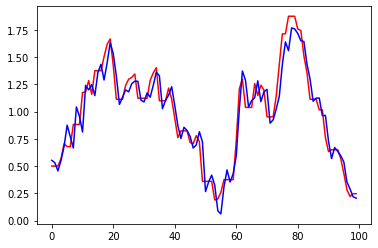

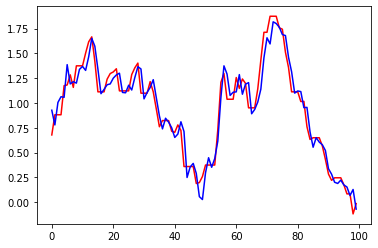

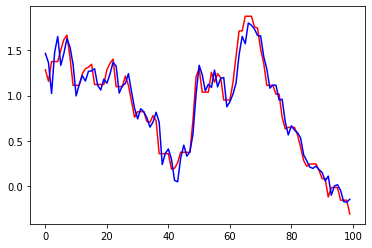

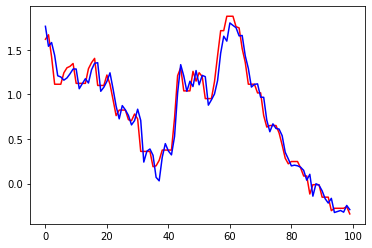

In [0]:
for step in range(235):
  x = x_total[step]
  y = y_total[step]

 
  x =x.numpy()
  x = Variable(torch.from_numpy(x[np.newaxis, :, np.newaxis]))
  y =y.numpy()
  y = Variable(torch.from_numpy(y[np.newaxis, :, np.newaxis]))


  prediction, h_state = rnn(x,h_state)  #rnn output

  h_state = Variable(h_state.data)
  #repack the hidden state, brea the conecction from last iteration

  loss = loss_func(prediction, y)         # cross entropy loss
  optimizer.zero_grad()                   # clear gradients for this training step
  loss.backward()                         # backpropagation, compute gradients
  optimizer.step()                        # apply gradients

  
  # plotting
  if step % 6 == 0:
      plt.plot( y.numpy().flatten(), 'r-')
      plt.plot( prediction.data.numpy().flatten(), 'b-')
      plt.draw(); plt.pause(0.05)

      # rojo real,   azul predicci'on

In [0]:
loss

tensor(0.0152, grad_fn=<MseLossBackward>)

## Prediccion sobre datos de validacion

Estimacion del mse de la serie completa y del ultimo valor

In [0]:

prediction.data.numpy().flatten()

array([ 1.5641052 ,  1.4890611 ,  1.6623404 ,  1.3492899 ,  1.108114  ,
        1.0912775 ,  1.2226171 ,  1.1904528 ,  1.2843758 ,  1.2962707 ,
        1.2905941 ,  1.1038747 ,  1.0802319 ,  1.2230624 ,  1.0866094 ,
        1.3334794 ,  1.3511136 ,  1.3587983 ,  1.0038247 ,  1.0840728 ,
        1.1876619 ,  1.224647  ,  1.0963969 ,  0.8559208 ,  0.7296915 ,
        0.86771905,  0.8602264 ,  0.80120885,  0.6893114 ,  0.699812  ,
        0.8197177 ,  0.7141502 ,  0.2250768 ,  0.38939106,  0.4140916 ,
        0.27007386,  0.13318351,  0.14392269,  0.22725648,  0.40037417,
        0.38835567,  0.39737463,  0.49467152,  0.8370855 ,  1.3831236 ,
        1.2253301 ,  0.9138372 ,  1.0500705 ,  1.1380259 ,  1.3200693 ,
        1.137213  ,  1.2219278 ,  1.189039  ,  0.8483709 ,  0.9492774 ,
        1.0469435 ,  1.1735327 ,  1.4972448 ,  1.6844935 ,  1.6088059 ,
        1.7714112 ,  1.7923706 ,  1.7518874 ,  1.655819  ,  1.6587065 ,
        1.4240469 ,  1.2766355 ,  1.0798733 ,  1.1225764 ,  1.15

In [0]:
pred = scaler.inverse_transform(prediction.data.numpy().flatten())

In [0]:
pred[-9:]

array([3273.7087, 3272.824 , 3277.9565, 3249.4028, 3262.5222, 3267.4211,
       3258.0813, 3263.8584, 3265.642 ], dtype=float32)

In [0]:
y_true

array([3277.14, 3277.14, 3258.84, 3262.05, 3262.05, 3262.05, 3262.05,
       3264.26, 3254.42])

In [0]:
y_true = df['TRM'].tail(9).to_numpy()
y_pred = pred[-10:]
y_pred = y_pred[:-1]

In [0]:
y_pred

array([3287.5347, 3273.7087, 3272.824 , 3277.9565, 3249.4028, 3262.5222,
       3267.4211, 3258.0813, 3263.8584], dtype=float32)

In [0]:
dif = np.average(y_true - y_pred)

mse = ((y_true - y_pred)**2).mean()
rmse = np.sqrt(mse)
print('la diferencia entre la prediccion y el dato real es de '+str(dif)+'pesos')
print('el MSE entre la prediccion y el dato real es de '+str(mse))
print('el RMSE entre la prediccion y el dato real es de '+str(rmse))

la diferencia entre la prediccion y el dato real es de -3.7010904947915657pesos
el MSE entre la prediccion y el dato real es de 98.29722811288786
el RMSE entre la prediccion y el dato real es de 9.914495857727102
